In [1]:
import seaborn as sns

import pandas as pd
import numpy as np

from pathlib import Path

import matplotlib.pyplot as plt
from imageio import imread
import marginal

from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

from sklearn.ensemble import RandomForestClassifier

import joblib

def read_grayscale_pngs(path, width=20, height=13):
    path = Path(path)
    if not path.exists():
        print("Path doesn't exist")
        return None

    # print(len([name for name in os.listdir('{}/.'.format(path)) if os.path.isfile(name)]))
    num_files = len(list(path.glob('**/*.png'))) # Calculate amount of files in directory
    # num_files = len([f for f in path.iterdir() if path.joinpath(f).is_file()]) # Calculate amount of files in directory

    ids = np.empty(num_files)
    images = np.empty((num_files, 13, 20))

    for i, image_path in enumerate(path.glob('**/*.png')):
        images[i] = np.array(imread(image_path))[:, :, 0] # Pixel data: It's grayscale so take only Red values from [R, G, B, A]
    return images

In [2]:
legal = read_grayscale_pngs("out/legal/orig")
illegal = read_grayscale_pngs("out/illegal/orig")

legal_test = read_grayscale_pngs("testing/legal")
illegal_test = read_grayscale_pngs("testing/illegal")


In [3]:
from scipy import ndimage
import operator
from scipy.ndimage.interpolation import rotate

def rotate_image(image, angle):
    rotated = ndimage.rotate(image, angle, mode='nearest')

    orig_average = weighted_average_indexes(image)

    rotated_average = weighted_average_indexes(rotated)
    if orig_average is None or rotated_average is None:
        return None

    # Shift the image so the center is at the same place
    center_diff = tuple(map(operator.sub, orig_average, rotated_average))
    median_value = np.median(rotated)

    shifted = ndimage.shift(rotated, np.array([center_diff[1], center_diff[0]]), cval=median_value)

    # Crop the image since it got bigger by rotation, it's centered so cutting the rest is enough
    return shifted[: image.shape[0], : image.shape[1]]


def weighted_average_indexes(image):
    # Values below 35 are not substantial and they mess with the average so replace them with zero
    image[image < 35] = 0
    total = np.sum(image) 

    if np.all(total == 0):
        return None

    val = 0
    for index, xsum in enumerate(np.sum(image, axis=0)):
        val += index * xsum
    xpos = val / total 

    val = 0
    for index, ysum in enumerate(np.sum(image, axis=1)):
        val += index * ysum
    ypos = val / total

    return xpos, ypos

In [4]:
features_list = []
for i, dataset in enumerate((legal, illegal, legal_test, illegal_test)):
    features = pd.DataFrame({
        "min": np.min(dataset, axis=(1,2)),
        "max": np.max(dataset, axis=(1,2)),
        "mean": np.mean(dataset, axis=(1,2)),
        "var": np.var(dataset, axis=(1,2)),
        "sum": np.sum(dataset, axis=(1,2)),
        "ptp": np.ptp(dataset, axis=(1,2)),
        "std": np.std(dataset, axis=(1,2)),
        "trace": np.trace(dataset, axis1=1, axis2=2),

        "mmeanx": np.array([marginal.mean(image, dim='x', meanNN_TF=False) for image in dataset]),
        "mmeanxTF": np.array([marginal.mean(image, dim='x', meanNN_TF=True) for image in dataset]),

        "msdx": np.array([marginal.std(image, dim='x', meanNN_TF=False) for image in dataset]),
        "msdxTF": np.array([marginal.std(image, dim='x', meanNN_TF=True) for image in dataset]),

        "mmeany": np.array([marginal.mean(image, dim='y', meanNN_TF=False) for image in dataset]),
        "mmeanyTF": np.array([marginal.mean(image, dim='y', meanNN_TF=True) for image in dataset]),

        "msdy": np.array([marginal.std(image, dim='y', meanNN_TF=False) for image in dataset]),
        "msdyTF": np.array([marginal.std(image, dim='y', meanNN_TF=True) for image in dataset]),

        "target": 0 if i % 2 == 0 else 1
    })
    features_list.append(features)

legal_features, illegal_features, legal_test_features, illegal_test_features = tuple(features_list)


features = pd.concat((legal_features, illegal_features))
test_features = pd.concat((legal_test_features, illegal_test_features))

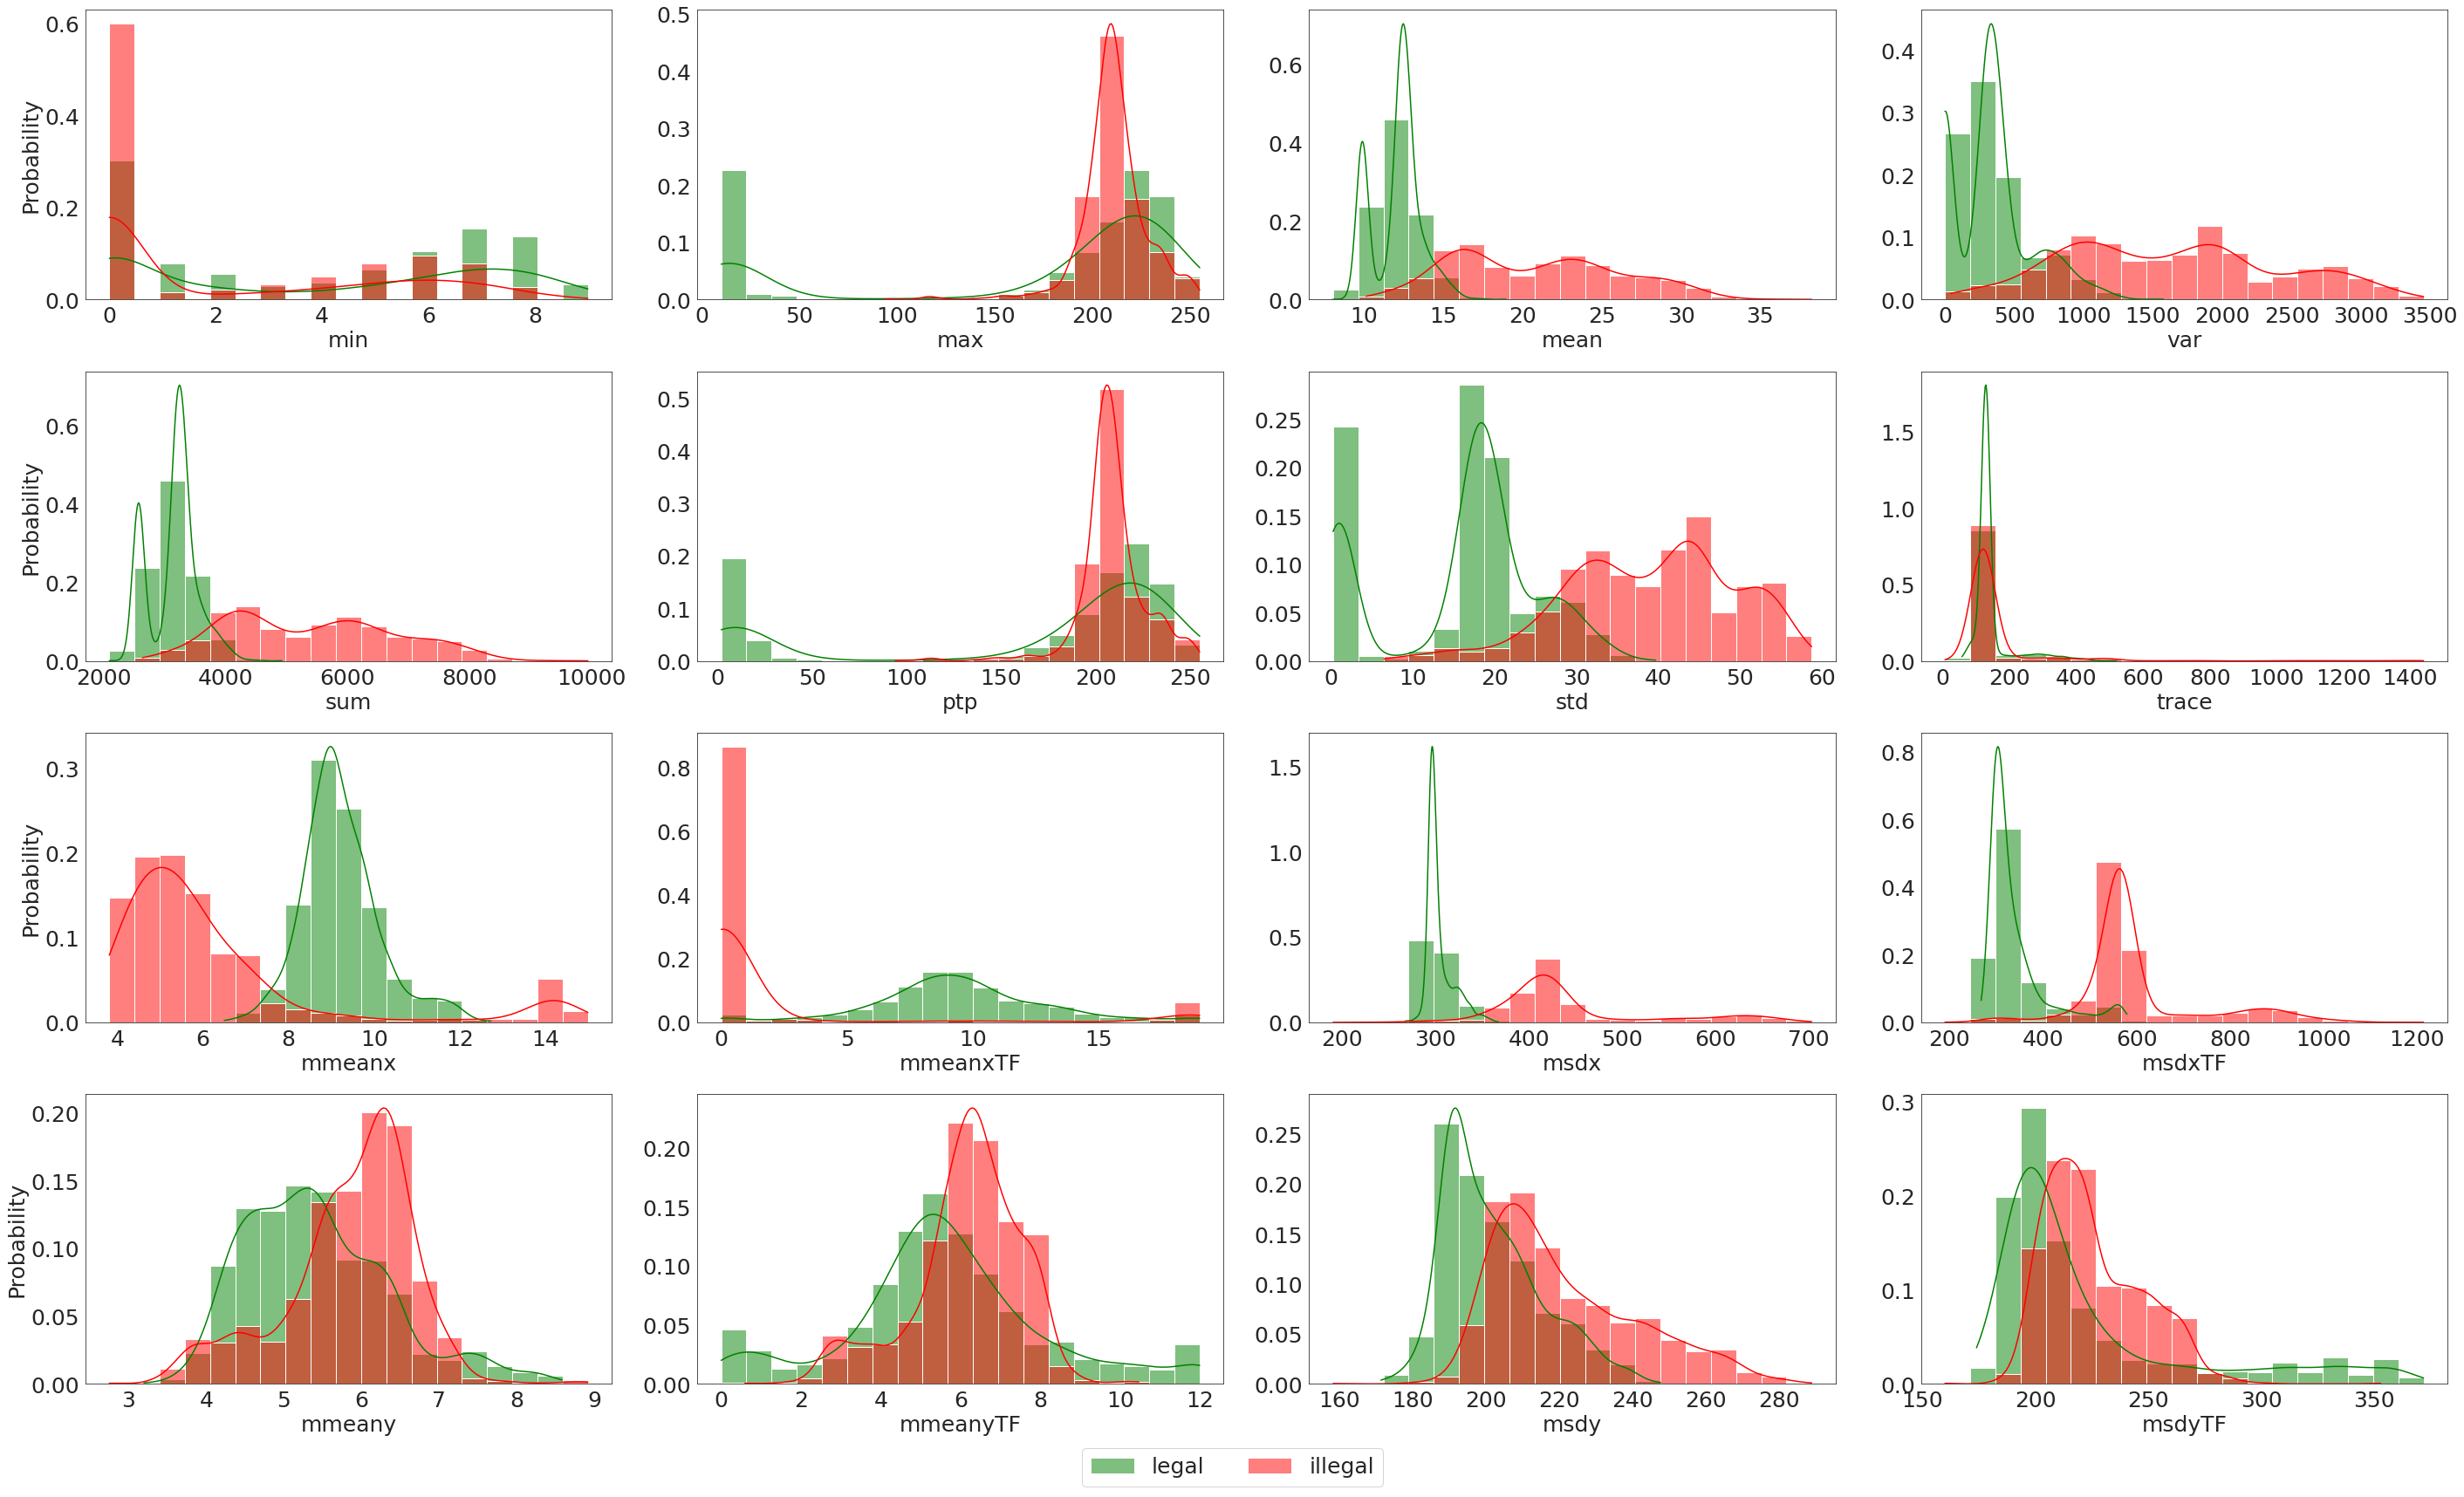

In [5]:
fig = plt.figure(figsize=(40, 25))
plt.rcParams.update({'font.size': 25})
n_bins = 20
i = 1
sns.set_style(style = 'white')

for feature in features.columns[: features.columns.slice_locs(end='msdyTF')[1]]: # Cycle through columns until and including "trace"
    ax = plt.subplot(4, 4, i)
    bins = np.linspace(features[feature].min(), features[feature].max(), n_bins)
    sns.histplot(data=legal_features, x=feature, kde=True, bins=bins, stat="probability", color='g', label='legal', ax=ax)
    sns.histplot(data=illegal_features, x=feature, kde=True, bins=bins, stat="probability", color='r', label='illegal', ax=ax)
    if i % 4 != 1:
        plt.ylabel(None)
    i += 1
handles, labels = fig.axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=2)
fig.tight_layout()
fig.subplots_adjust(top=0.95, bottom=0.075)
plt.savefig('figures/ml_feature_distribution.pdf')

<Figure size 2160x2880 with 0 Axes>

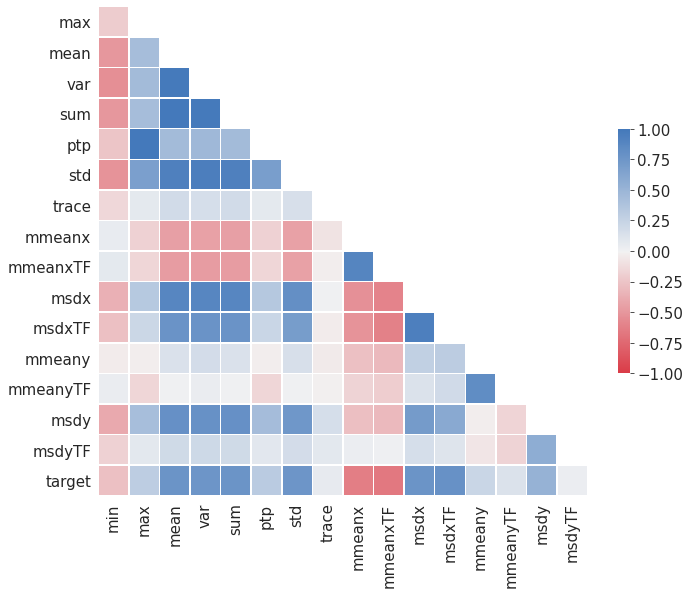

In [6]:
plt.figure(figsize=(30,40))

corr = features.corr().iloc[1: , :-1]
mask = np.triu(np.ones_like(corr, dtype=np.bool), k=1)
sns.set_style(style = 'white')
plt.rcParams.update({'font.size': 15})
fig, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(10, 250, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap,
        square=True, vmin=-1.0, vmax=1.0,
        linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
plt.savefig('figures/ml_feature_corr.pdf')

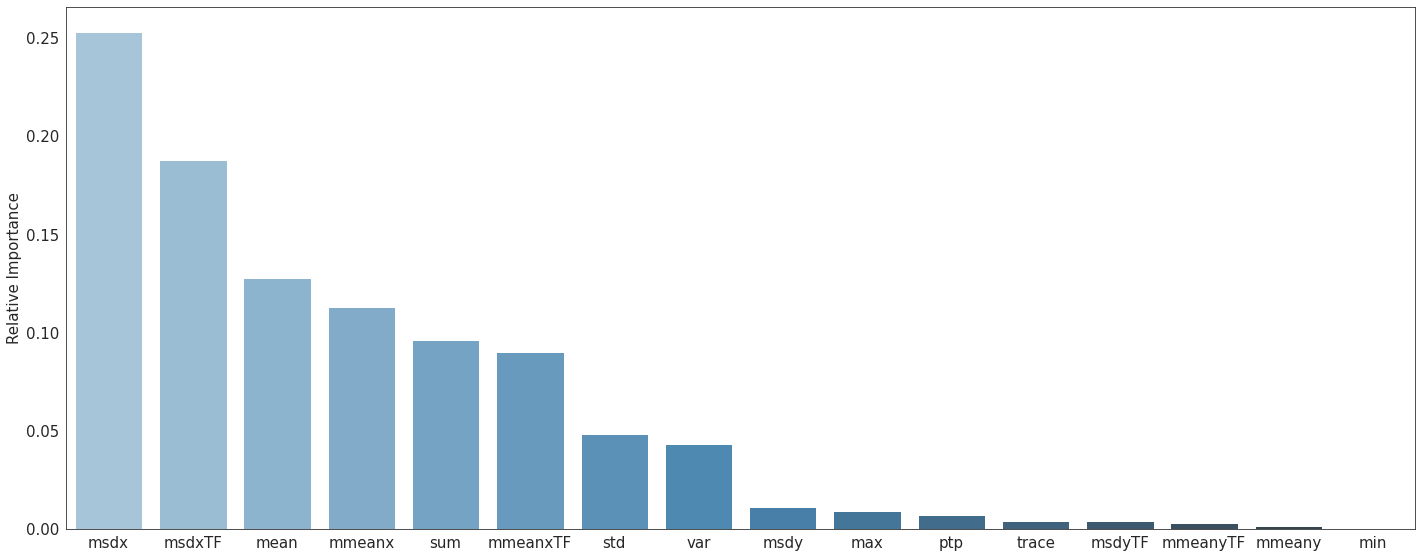

In [7]:
model = RandomForestClassifier(n_estimators=200)

features_selected = []

X_train = features.drop('target', axis=1) if len(features_selected)==0 else features[features_selected]
Y_train = features['target']

model.fit(X_train, Y_train)# plotting feature importances
features_forest = features.drop('target', axis=1).columns
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

fig = plt.figure(figsize=(20,8))

sns.barplot(x=[features_forest[i] for i in indices], y=importances[indices], palette="Blues_d")
plt.xlabel(None)
plt.ylabel('Relative Importance')
plt.tight_layout()
plt.savefig("figures/ml_feature_importances.pdf")

